In [1]:
import hnswlib
import numpy as np
from libs.nodes import *
import matplotlib.pyplot as plt

# Approx Graph w/ Inferred Nodes via KNN

In [2]:
def nodes_to_matrix(nodes):
    dim = max([max(x) for x in nodes]) # attributes are 1-indexed
    node_amnt = len(nodes)

    # Convert to sparse matrix
    data = np.zeros((node_amnt, dim))
    for i in range(node_amnt):
        for x in nodes[i]:
            data[i][x-1] = 1
    
    return data


def matrix_to_nodes(matrix):
    nodes = []
    for i in range(len(matrix)):
        next = node()
        for j in range(len(matrix[i])):
            if matrix[i][j] == 1:
                next |= {j+1}
        nodes.append(next)
    return nodes


def build_index(data, ef_const, M):
    node_amnt = len(data)
    dim = len(data[0])

    # using l2 distance
    index = hnswlib.Index(space='l2', dim=dim)
    # index = hnswlib.BFIndex(space='l2', dim=dim)
    index.init_index(max_elements=node_amnt, ef_construction=ef_const, M=M)
    # index.init_index(max_elements=node_amnt)
    index.add_items(data)
    return index


def search(index, data, k, ef):
    k += 1 # first result is always the node itself
    index.set_ef(ef)
    results, _ = index.knn_query(data, k=k)

    ids = index.get_ids_list()
    items = matrix_to_nodes(index.get_items(ids))
    results = [[items[x] for x in knn] for knn in results]

    root = [x[0] for x in results]
    nn = [x[1:] for x in results]
    results = list(zip(root, nn))
    return results


def knn(path):
    nodes = parse_nodes(path)
    matrix = nodes_to_matrix(nodes)
    ef = 100
    index = build_index(matrix, ef_const=ef, M=50)
    results = search(index, matrix, k=100, ef=ef)
    return results

In [3]:
knn_pre_inf = knn("../../data/int_adj/setA/18837_out.nodes")
knn_in_time = knn("../../data/int_adj/setA/200_in.nodes")

In [4]:
knn_in_time[:10]

[((1,2,3,5,11,42,64,68,103,162,228,238,264,295,310,327,329,353,422,468,496,563,570,673,679,680,681,682,685),
  [(1,2,3,5,11,42,68,103,224,228,238,264,295,310,327,329,353,405,422,468,496,563,570,663,673,679,680,681,682,685),
   (1,2,3,5,55,144,153,170,171,212,261,293,348,378,420,426,439,448,477,484,529,538,558,610,628,638,639,652,662,670,691,717,736),
   (1,2,3,5,55,80,97,137,144,171,201,212,261,293,378,407,426,431,451,477,525,529,576,610,638,652,662,670,674,691,717,718,736),
   (2,3,5,11,327),
   (1,2,3,5,19,83,241,327,502),
   (1,2,3,5,144,153,170,171,189,212,261,293,348,378,420,426,439,448,484,529,538,558,610,628,638,639,652,658,662,670,674,691,717),
   (2,3,5,652),
   (1,2,3,5,16,17,30,426),
   (2,3,5,153,170,171,212,261,293,348,378,420,426,439,448,484,529,538,558,610,628,638,639,658,662,670,674,717,736),
   (1,2,3,5,55,144,153,170,171,204,212,261,293,348,378,420,426,439,448,484,529,538,558,610,628,638,639,658,662,670,674,691,717,736),
   (1,2,3,5,11,42,68,103,132,228,238,264,265,29

## In-Time Inference

Take a set of (root, nn) and compute all intersections between $n \in nn$ and $root$... repeatedly on generated nodes.
Generated nodes are cached and added to the index for another knn search and round of inference.

In [5]:
def in_time_inference(initial_nodes):
    

nodes = [
    node({1,2,3,4}),
    node({2,3,4,5}),
    node({4,5,8,9})
]

test_knn = [
    (0, [1, 2]),
    (1, [0]),
    (2, [0, 1])
]

test_data = [(nodes[root], [nodes[x] for x in nn]) for root, nn in test_knn]
expand_candidates(test_data)

[((1,2,3,4), {(4), (4,5,8,9), (2,3,4), (2,3,4,5)}),
 ((2,3,4,5), {(2,3,4), (1,2,3,4)}),
 ((4,5,8,9), {(4), (4,5), (1,2,3,4), (2,3,4,5)})]

In [6]:
knn_in_time = expand_candidates(knn_in_time)

## Filtering for distance $\le d$
## Filtering ($a \to b$) $b \subset a$

In [7]:
def apply_filters(results: list[tuple[node, list[node]]], d=5):
    dist = lambda a, b: len(a ^ b)
    close = lambda root, list: [x for x in list if dist(x, root) <= d]
    sub = lambda root, list: [x for x in list if x.issubset(root)]
    return [(root, close(root, n) and sub(root, n)) for root, n in results]

test_data = [
    [node({1,2,3,4}), [node({1,2,3}), node({1,2,3,4,5})]],
    [node({2,3,4,5}), [node({1,2,9}), node({1,2,4,5})]],
    [node({4,5,8,9}), [node({1,2,3,4,5}), node({1,2,3,4,5,6}), node({4, 5}), node({4})]]
]

apply_filters(test_data, d=2)

[((1,2,3,4), [(1,2,3)]), ((2,3,4,5), []), ((4,5,8,9), [(4,5), (4)])]

In [8]:
d = 3
candidates_pre_inf = apply_filters(knn_pre_inf, d)
candidates_in_time = apply_filters(knn_in_time, d)

# Results

## Candidates per node

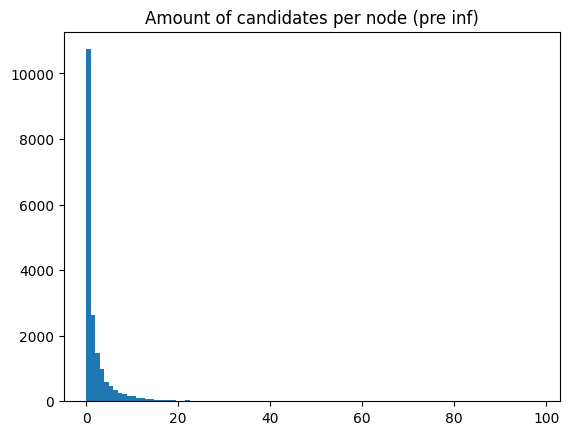

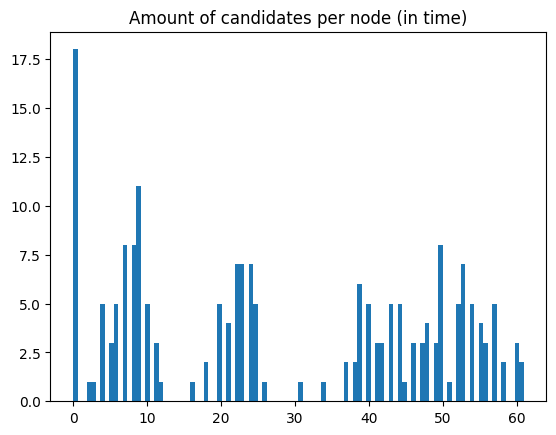

In [9]:
dist_metric = lambda x: [len(candidates) for root, candidates in x]
plt.hist(dist_metric(candidates_pre_inf), bins=100)
plt.title("Amount of candidates per node (pre inf)")
plt.show()
plt.hist(dist_metric(candidates_in_time), bins=100)
plt.title("Amount of candidates per node (in time)")
plt.show()

## Attribute Gain

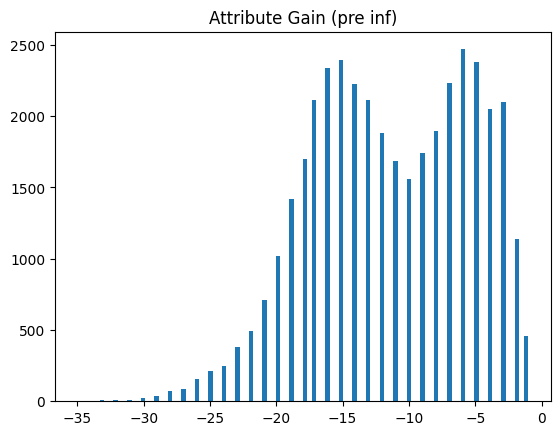

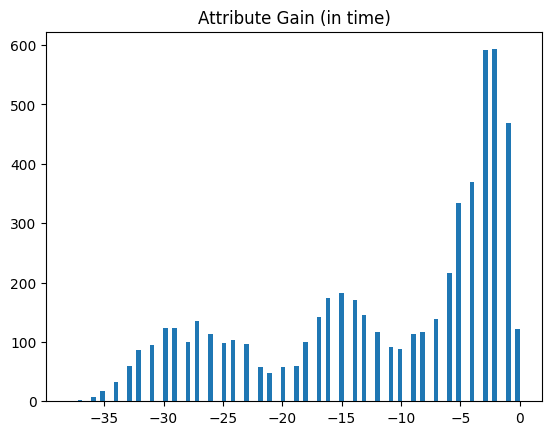

In [10]:
def gain_metric(data):
    results = []
    for root, candidates in data:
        for candidate in candidates:
            results.append(len(candidate) - len(root))
    return results

plt.hist(gain_metric(candidates_pre_inf), bins=100)
plt.title("Attribute Gain (pre inf)")
plt.show()

plt.hist(gain_metric(candidates_in_time), bins=100)
plt.title("Attribute Gain (in time)")
plt.show()